In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model

In [3]:
! unzip "/content/drive/My Drive/AV_sentiment_analysis.zip"
! ls

Archive:  /content/drive/My Drive/AV_sentiment_analysis.zip
  inflating: test_oJQbWVk.csv        
  inflating: train_2kmZucJ.csv       
  inflating: sample_submission_LnhVWA4.csv  
drive	     sample_submission_LnhVWA4.csv  train_2kmZucJ.csv
sample_data  test_oJQbWVk.csv


In [4]:
train = pd.read_csv("./train_2kmZucJ.csv")
train = train[["label", "tweet"]]
test = pd.read_csv("./test_oJQbWVk.csv")
train.head()

,label,tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,0,Finally a transparant silicon case ^^ Thanks t...
2,0,We love this! Would you go? #talk #makememorie...
3,0,I'm wired I know I'm George I was made that wa...
4,1,What amazing service! Apple won't even talk to...


In [17]:
def clean_text(df):
    df["tweet"] = df["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
    df["tweet"] = df["tweet"].str.replace("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))", "")
    df["tweet"] = df["tweet"].str.replace("[^\w\s]", "")

    return df

train = clean_text(train)
test = clean_text(test)
train.head()

,label,tweet
0,0,sibling sister fun girls selfie selca frontcam...
1,0,tonight in the cirebon city cirebon photograph...
2,1,totally avoided a free u2 al by not using itun...
3,0,yeah finally i have samsung galaxy s3 me samsu...
4,0,amazing clouds and not roller master 4k roller...


In [18]:
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,label,tweet
0,0,love it instagram instapic instashoot instawat...
1,0,phone necessitiescar clips buy one get 1 click...
2,1,well its 1217 ios 7 isnt out yet im pissed app...
3,1,since i updated my phone earlier it has just g...
4,1,and why is circletwelve not asking moneybringi...


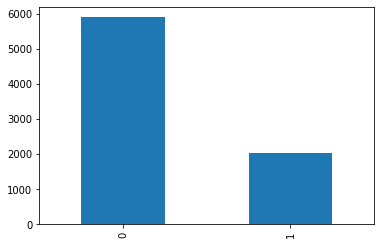

In [19]:
train["label"].value_counts().plot(kind="bar")

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_t, y_v = train_test_split(train["tweet"], train["label"], test_size=0.1, random_state=42)

In [10]:
! pip install sentencepiece tf-sentencepiece

     |████████████████████████████████| 1.1MB 18.0MB/s 
     |████████████████████████████████| 2.1MB 55.3MB/s 


In [13]:
! pip install tensorflow_text

     |████████████████████████████████| 3.0MB 12.9MB/s 


In [14]:
import tensorflow_hub as hub
import tensorflow_text

use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [26]:
example1 = ["hello there"]
example2 = ["hi there"]

emb1 = use(example1)
emb2 = use(example2)

np.inner(emb1, emb2).flatten()[0]

0.97698355

In [30]:
! pip install tqdm
from tqdm import tqdm_notebook
x_t = []
x_v = []

for row in tqdm_notebook(x_train):
    emb = use([row])
    review_emb = tf.reshape(emb, [-1]).numpy()
    x_t.append(review_emb)

for row in tqdm_notebook(x_valid):
    emb = use([row])
    review_emb = tf.reshape(emb, [-1]).numpy()
    x_v.append(review_emb)

x_t = np.array(x_t)
x_v = np.array(x_v)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [32]:
y_t_padded = []
for ele in y_t:
    y_t_padded.append(np.eye(2)[ele])
y_t_padded = np.array(y_t_padded)

y_v_padded = []
for ele in y_v:
    y_v_padded.append(np.eye(2)[ele])
y_v_padded = np.array(y_v_padded)

In [33]:
print("Training Data", x_t.shape, y_t_padded.shape)
print("Validation Data", x_v.shape, y_v_padded.shape)

Training Data (7128, 512) (7128, 2)
Validation Data (792, 512) (792, 2)


In [42]:
# prepare the data so that an LSTM can take in
x_t, x_v = x_t.reshape(-1, 1, 512), x_v.reshape(-1, 1, 512)
print(x_t.shape, x_v.shape)

(7128, 1, 512) (792, 1, 512)


In [49]:
total_data = train["tweet"].values.tolist()
total_x = []

for row in tqdm_notebook(total_data):
    emb = use([row])
    review_emb = tf.reshape(emb, [-1]).numpy()
    total_x.append(review_emb)
total_x = np.array(total_x)
total_x = total_x.reshape(-1, 1, 512)
print("Total X", total_x.shape)

total_y = []
for entry in train["label"]:
    one_hot = np.eye(2)[entry]
    total_y.append(one_hot)

total_y = np.array(total_y)
print("Total Y", total_y.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Total X (7920, 1, 512)
Total Y (7920, 2)


In [75]:
model = Sequential([
                    tf.keras.layers.Input(shape=(1, 512,)),
                    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
                    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
                    Dropout(0.2),
                    Dense(256, activation=tf.nn.relu),
                    Dropout(0.2),
                    Dense(128, activation=tf.nn.relu),
                    Dense(2, activation=tf.nn.softmax)
])

model.compile(loss=tf.nn.softmax_cross_entropy_with_logits,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["acc"])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_18 (Bidirectio (None, 1, 256)            656384    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 128)               164352    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_32 (Dense)             (None, 2)               

In [56]:
from matplotlib import pyplot as plt

def plot_history(history, val=True):
    loss = history.history["loss"]
    acc = history.history["acc"]
    if val:
        val_loss = history.history["val_loss"]
        val_acc = history.history["val_acc"]

    plt.figure(figsize=(8, 8))
    plt.plot(loss, c="b", label="Training Loss", alpha=0.6)
    if val:
        plt.plot(val_loss, c="r", label="Validation Loss", alpha=0.6)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.plot(acc, c="b", label="Training Acc", alpha=0.6)
    if val:
        plt.plot(val_acc, c="r", label="Validation Acc", alpha=0.6)
    plt.legend()
    plt.show()

In [76]:
history = model.fit(x_t, y_t_padded, epochs=20, verbose=1, batch_size=16, validation_data=(x_v, y_v_padded))

Epoch 1/20
446/446 [==============================] - 13s 30ms/step - loss: 0.5144 - acc: 0.8116 - val_loss: 0.4201 - val_acc: 0.8838
Epoch 2/20
446/446 [==============================] - 12s 27ms/step - loss: 0.4098 - acc: 0.9001 - val_loss: 0.4088 - val_acc: 0.9015
Epoch 3/20
446/446 [==============================] - 11s 25ms/step - loss: 0.4035 - acc: 0.9075 - val_loss: 0.4036 - val_acc: 0.9104
Epoch 4/20
446/446 [==============================] - 11s 24ms/step - loss: 0.3988 - acc: 0.9129 - val_loss: 0.4054 - val_acc: 0.9053
Epoch 5/20
446/446 [==============================] - 11s 25ms/step - loss: 0.3945 - acc: 0.9171 - val_loss: 0.4071 - val_acc: 0.9040
Epoch 6/20
446/446 [==============================] - 12s 26ms/step - loss: 0.3933 - acc: 0.9176 - val_loss: 0.4072 - val_acc: 0.9028
Epoch 7/20
446/446 [==============================] - 12s 27ms/step - loss: 0.3906 - acc: 0.9217 - val_loss: 0.4072 - val_acc: 0.9028
Epoch 8/20
446/446 [==============================] - 11s 25ms

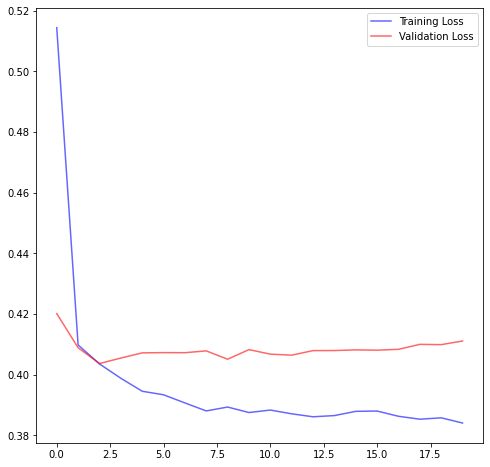

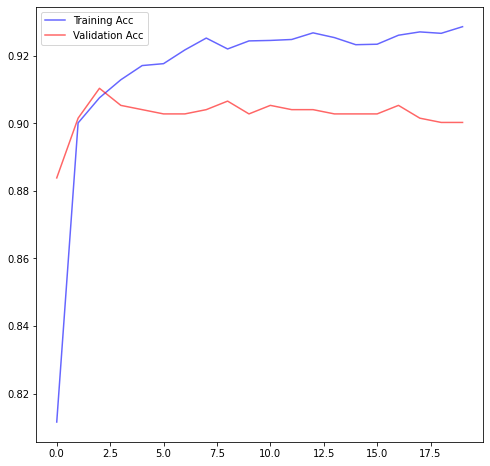

In [77]:
plot_history(history)

In [58]:
model2 = Sequential([
                    tf.keras.layers.Input(shape=(1, 512,)),
                    Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
                    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
                    Dropout(0.2),
                    Dense(256, activation=tf.nn.relu),
                    Dropout(0.2),
                    Dense(128, activation=tf.nn.relu),
                    Dense(2, activation=tf.nn.softmax)
])

model2.compile(loss=tf.nn.softmax_cross_entropy_with_logits,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["acc"])

model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 1, 200)            490400    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 128)               135680    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 2)                

In [59]:
history = model2.fit(total_x, total_y, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
248/248 [==============================] - 6s 25ms/step - loss: 0.5627 - acc: 0.7635
Epoch 2/50
248/248 [==============================] - 6s 25ms/step - loss: 0.4249 - acc: 0.8958
Epoch 3/50
248/248 [==============================] - 6s 23ms/step - loss: 0.4057 - acc: 0.9061
Epoch 4/50
248/248 [==============================] - 6s 23ms/step - loss: 0.4020 - acc: 0.9086
Epoch 5/50
248/248 [==============================] - 5s 22ms/step - loss: 0.4018 - acc: 0.9072
Epoch 6/50
248/248 [==============================] - 6s 26ms/step - loss: 0.3969 - acc: 0.9154
Epoch 7/50
248/248 [==============================] - 6s 24ms/step - loss: 0.3948 - acc: 0.9181
Epoch 8/50
248/248 [==============================] - 6s 23ms/step - loss: 0.3934 - acc: 0.9188
Epoch 9/50
248/248 [==============================] - 6s 25ms/step - loss: 0.3927 - acc: 0.9198
Epoch 10/50
248/248 [==============================] - 7s 28ms/step - loss: 0.3913 - acc: 0.9206
Epoch 11/50
248/248 [==================

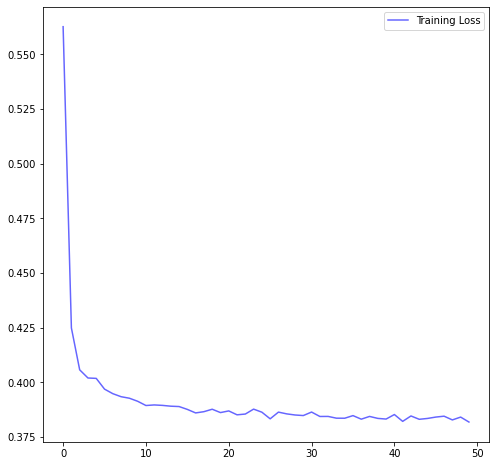

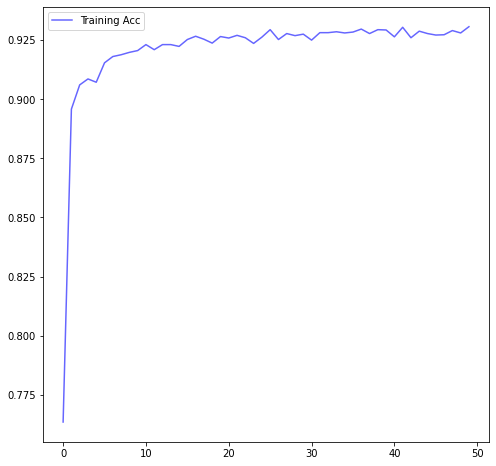

In [60]:
plot_history(history, val=False)

In [61]:
test.head()

,id,tweet
0,7921,i hate the new iphone upgrade wont let me down...
1,7922,currently shitting my fucking pants apple imac...
2,7923,id like to puts some cdroms on my ipad is that...
3,7924,my ipod is officially dead i lost all my pictu...
4,7925,been fighting itunes all night i only want the...


In [63]:
test_data = []
for row in tqdm_notebook(test.tweet.values):
    emb = use([row])
    review_emb = tf.reshape(emb, [-1]).numpy()
    test_data.append(review_emb)
test_data = np.array(test_data)
test_data = test_data.reshape(-1, 1, 512)
print("Test Data", test_data.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Test Data (1953, 1, 512)


In [68]:
test_pred = model.predict(test_data)
predictions = [np.argmax(ele) for ele in test_pred]

submission = pd.DataFrame({"id": test.id.values.tolist(), "label": predictions})
submission.head()

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,1
4,7925,1


In [69]:
submission.to_csv("./submission2.csv", index=False)

In [71]:
model.save("/content/drive/My Drive/model_with_val.h5")
model2.save("/content/drive/My Drive/model_total_data.h5")

In [78]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, roc_auc_score, confusion_matrix, accuracy_score

def train_model(clf, x_t, y_t, x_v, y_v):
    clf.fit(x_t, y_t)
    print("Training Accuracy", clf.score(x_t, y_t))
    
    print("Validation Accuracy", clf.score(x_v, y_v))
    y_pred = clf.predict(x_v)
    print("F1 Score", f1_score(y_pred, y_v))
    print('validation roc_auc score',roc_auc_score(y_v,clf.predict_proba(x_v)[::,-1]))
    print("Confusion Matrix\n", confusion_matrix(y_pred, y_v))

    return clf

xgb = XGBClassifier(n_estimators=500, max_depth=5,learning_rate=0.1,scale_pos_weight=1.4266790777602751)
lgr = LogisticRegression(n_jobs=1)
gbc = GradientBoostingClassifier(n_estimators=500)

In [84]:
%%time
train_model(xgb, x_t.reshape(-1, 512), y_t, x_v.reshape(-1, 512), y_v)

Training Accuracy 1.0
Validation Accuracy 0.8825757575757576
F1 Score 0.7546174142480211
validation roc_auc score 0.9540941270760052
Confusion Matrix
 [[556  42]
 [ 51 143]]
CPU times: user 2min 43s, sys: 80.8 ms, total: 2min 43s
Wall time: 2min 44s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.4266790777602751,
              seed=None, silent=None, subsample=1, verbosity=1)

In [85]:
%%time
train_model(lgr, x_t.reshape(-1, 512), y_t, x_v.reshape(-1, 512), y_v)

Training Accuracy 0.9161054994388328
Validation Accuracy 0.9078282828282829
F1 Score 0.8053333333333332
validation roc_auc score 0.9578966116033661
Confusion Matrix
 [[568  34]
 [ 39 151]]
CPU times: user 333 ms, sys: 0 ns, total: 333 ms
Wall time: 180 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [86]:
%%time
train_model(gbc, x_t.reshape(-1, 512), y_t, x_v.reshape(-1, 512), y_v)

Training Accuracy 0.989337822671156
Validation Accuracy 0.8825757575757576
F1 Score 0.7394957983193278
validation roc_auc score 0.9456431720023154
Confusion Matrix
 [[567  53]
 [ 40 132]]
CPU times: user 10min, sys: 0 ns, total: 10min
Wall time: 10min


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [88]:
import pickle

pickle.dump(xgb, open("/content/drive/My Drive/xgb_av_sa.pickle", "wb"))
pickle.dump(lgr, open("/content/drive/My Drive/lgr_av_sa.pickle", "wb"))
pickle.dump(gbc, open("/content/drive/My Drive/gbc_av_sa.pickle", "wb"))

In [89]:
test_pred = lgr.predict(test_data.reshape(-1, 512))
test_pred

array([1, 0, 1, ..., 1, 0, 0])

In [91]:
submission = pd.DataFrame({"id": test.id.values, "label": test_pred})
submission.to_csv("/content/drive/My Drive/submission3.csv")
submission.head()

,id,label
0,7921,1
1,7922,0
2,7923,1
3,7924,1
4,7925,1


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train["tweet"])
word_index = tokenizer.word_index

print("Vocab Size", len(word_index) + 1)

x_t = tokenizer.texts_to_sequences(x_train)
x_v = tokenizer.texts_to_sequences(x_valid)

Vocab Size 18579


In [ ]:
max_len = max([len(x.split()) for x in train["tweet"]])
print("Max Len", max_len)
vocab_size = len(word_index) + 1

Max Len 51


In [ ]:
x_t_padded = pad_sequences(x_t, padding="post", maxlen=max_len)
x_v_padded = pad_sequences(x_v, padding="post", maxlen=max_len)

print("Train Data Shape", x_t_padded.shape, "Validation Data Shape", x_v_padded.shape)

Train Data Shape (7128, 51) Validation Data Shape (792, 51)


In [ ]:
model = Sequential([
                    Embedding(vocab_size, 300, input_shape=[max_len,]),
                    Dropout(0.4),
                    # tf.keras.layers.GlobalAveragePooling1D(),
                    BatchNormalization(),
                    Bidirectional(LSTM(150, recurrent_dropout=0.2, dropout=0.2, return_sequences=True)),
                    BatchNormalization(),
                    Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)),
                    Dropout(0.2),
                    BatchNormalization(),
                    Dense(128, activation=tf.nn.relu),
                    Dense(2, activation=tf.nn.softmax)
])

model.compile(loss=tf.nn.softmax_cross_entropy_with_logits, 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["acc"])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 51, 300)           5573700   
_________________________________________________________________
dropout_12 (Dropout)         (None, 51, 300)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 51, 300)           1200      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 51, 300)           541200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 51, 300)           1200      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               320800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 200)              

In [ ]:
y_t_padded = []
for ele in y_t:
    y_t_padded.append(np.eye(2)[ele])
y_t_padded = np.array(y_t_padded)

y_v_padded = []
for ele in y_v:
    y_v_padded.append(np.eye(2)[ele])
y_v_padded = np.array(y_v_padded)

In [ ]:
history = model.fit(x_t_padded, y_t_padded, epochs=20, batch_size=64, validation_data=(x_v_padded, y_v_padded), verbose=1)

Epoch 1/20
112/112 [==============================] - 131s 1s/step - loss: 0.6332 - acc: 0.6403 - val_loss: 0.6082 - val_acc: 0.7689
Epoch 2/20
112/112 [==============================] - 129s 1s/step - loss: 0.5074 - acc: 0.8046 - val_loss: 0.5195 - val_acc: 0.8068
Epoch 3/20
112/112 [==============================] - 128s 1s/step - loss: 0.4559 - acc: 0.8579 - val_loss: 0.4601 - val_acc: 0.8485
Epoch 4/20
112/112 [==============================] - 129s 1s/step - loss: 0.4250 - acc: 0.8872 - val_loss: 0.4587 - val_acc: 0.8510
Epoch 5/20
112/112 [==============================] - 128s 1s/step - loss: 0.4060 - acc: 0.9061 - val_loss: 0.4461 - val_acc: 0.8624
Epoch 6/20
112/112 [==============================] - 129s 1s/step - loss: 0.3944 - acc: 0.9192 - val_loss: 0.4512 - val_acc: 0.8510
Epoch 7/20
112/112 [==============================] - 128s 1s/step - loss: 0.3875 - acc: 0.9244 - val_loss: 0.4457 - val_acc: 0.8636
Epoch 8/20
112/112 [==============================] - 134s 1s/step - 

In [ ]:
loss = history.history["loss"]
acc = history.history["acc"]
val_loss = history.history["val_loss"]
val_acc = history.history["val_acc"]

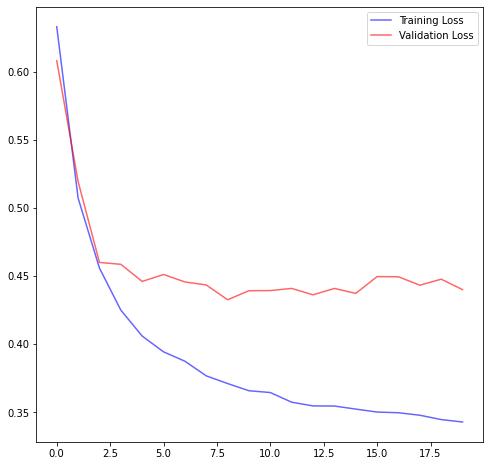

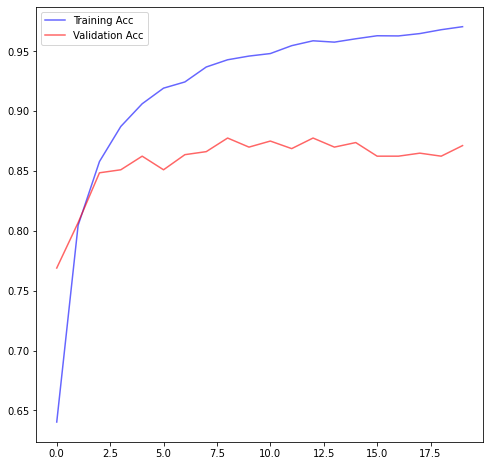

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(loss, c="b", label="Training Loss", alpha=0.6)
plt.plot(val_loss, c="r", label="Validation Loss", alpha=0.6)
plt.legend()
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(acc, c="b", label="Training Acc", alpha=0.6)
plt.plot(val_acc, c="r", label="Validation Acc", alpha=0.6)
plt.legend()
plt.show()

In [ ]:
simple_model = Sequential([
                    Embedding(vocab_size, 300, input_shape=[max_len,]),
                    Dropout(0.4),
                    tf.keras.layers.GlobalAveragePooling1D(),
                    # BatchNormalization(),
                    # Bidirectional(LSTM(150, recurrent_dropout=0.2, dropout=0.2, return_sequences=True)),
                    # BatchNormalization(),
                    # Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)),
                    BatchNormalization(),
                    Dense(256, activation=tf.nn.relu),
                    Dropout(0.3),
                    BatchNormalization(),
                    Dense(128, activation=tf.nn.relu),
                    Dropout(0.2),
                    Dense(2, activation=tf.nn.softmax)
])

simple_model.compile(loss=tf.nn.softmax_cross_entropy_with_logits, 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["acc"])

simple_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 51, 300)           5573700   
_________________________________________________________________
dropout_18 (Dropout)         (None, 51, 300)           0         
_________________________________________________________________
global_average_pooling1d_7 ( (None, 300)               0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 300)               1200      
_________________________________________________________________
dense_34 (Dense)             (None, 256)               77056     
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)             

In [ ]:
history = simple_model.fit(x_t_padded, y_t_padded, epochs=50, batch_size=64, validation_data=(x_v_padded, y_v_padded), verbose=1)

Epoch 1/50
112/112 [==============================] - 8s 73ms/step - loss: 0.6570 - acc: 0.6114 - val_loss: 0.6581 - val_acc: 0.7689
Epoch 2/50
112/112 [==============================] - 8s 71ms/step - loss: 0.5165 - acc: 0.7971 - val_loss: 0.6117 - val_acc: 0.7689
Epoch 3/50
112/112 [==============================] - 8s 71ms/step - loss: 0.4720 - acc: 0.8396 - val_loss: 0.5571 - val_acc: 0.7816
Epoch 4/50
112/112 [==============================] - 8s 72ms/step - loss: 0.4506 - acc: 0.8576 - val_loss: 0.5033 - val_acc: 0.8396
Epoch 5/50
112/112 [==============================] - 8s 72ms/step - loss: 0.4307 - acc: 0.8824 - val_loss: 0.4653 - val_acc: 0.8573
Epoch 6/50
112/112 [==============================] - 8s 72ms/step - loss: 0.4164 - acc: 0.8973 - val_loss: 0.4435 - val_acc: 0.8611
Epoch 7/50
112/112 [==============================] - 8s 72ms/step - loss: 0.4053 - acc: 0.9084 - val_loss: 0.4524 - val_acc: 0.8447
Epoch 8/50
112/112 [==============================] - 8s 72ms/step - 

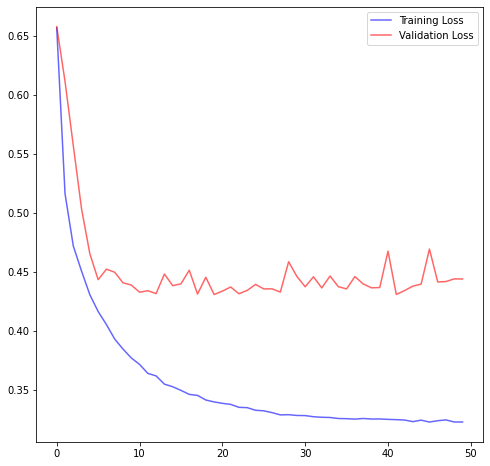

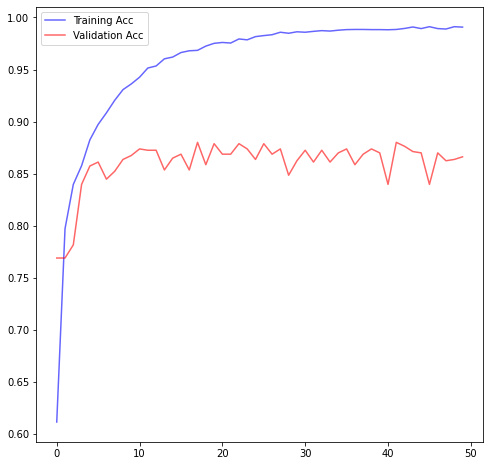

In [ ]:
loss = history.history["loss"]
acc = history.history["acc"]
val_loss = history.history["val_loss"]
val_acc = history.history["val_acc"]

plt.figure(figsize=(8, 8))
plt.plot(loss, c="b", label="Training Loss", alpha=0.6)
plt.plot(val_loss, c="r", label="Validation Loss", alpha=0.6)
plt.legend()
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(acc, c="b", label="Training Acc", alpha=0.6)
plt.plot(val_acc, c="r", label="Validation Acc", alpha=0.6)
plt.legend()
plt.show()

In [ ]:
pred_X = tokenizer.texts_to_sequences(test["tweet"])
pred_X = pad_sequences(pred_X, padding="post", maxlen=max_len)

pred_X.shape

(1953, 51)

In [ ]:
y_pred = model.predict(pred_X)
y_pred

array([[5.7060952e-08, 1.0000000e+00],
       [3.7713800e-04, 9.9962282e-01],
       [7.1779482e-07, 9.9999928e-01],
       ...,
       [3.7680871e-07, 9.9999964e-01],
       [1.9702084e-06, 9.9999797e-01],
       [9.9986231e-01, 1.3761289e-04]], dtype=float32)

In [ ]:
predictions = []
for row in y_pred:
    predictions.append(np.argmax(y_pred))

In [ ]:
submission = pd.DataFrame({"id": test["id"].values.tolist(), "label": predictions})
submission.head()

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,1
4,7925,1


In [ ]:
submission.to_csv("./submission.csv", index=False)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

x_train, x_valid, y_t, y_v = train_test_split(train["tweet"], train["label"], test_size=0.1, random_state=42)

tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
tfidf.fit(train["tweet"])

x_t = tfidf.transform(x_train)
x_v = tfidf.transform(x_valid)

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, roc_auc_score, confusion_matrix, accuracy_score

def train_model(clf, x_t, y_t, x_v, y_v):
    clf.fit(x_t, y_t)
    print("Training Accuracy", clf.score(x_t, y_t))
    
    print("Validation Accuracy", clf.score(x_v, y_v))
    y_pred = clf.predict(x_v)
    print("F1 Score", f1_score(y_pred, y_v))
    print('validation roc_auc score',roc_auc_score(y_v,clf.predict_proba(x_v)[::,-1]))
    print("Confusion Matrix\n", confusion_matrix(y_pred, y_v))

    return clf

xgb = XGBClassifier(n_estimators=500, max_depth=5,learning_rate=0.1,scale_pos_weight=1.4266790777602751)
lgr = LogisticRegression(n_jobs=1)
gbc = GradientBoostingClassifier(n_estimators=500)

In [ ]:
%%time
train_model(xgb, x_t, y_t, x_v, y_v)

Training Accuracy 0.938692480359147
Validation Accuracy 0.8724747474747475
F1 Score 0.754257907542579
validation roc_auc score 0.9368429745241339
Confusion Matrix
 [[536  52]
 [ 49 155]]
CPU times: user 5.48 s, sys: 8.14 ms, total: 5.49 s
Wall time: 5.49 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.4266790777602751,
              seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
%%time
train_model(lgr, x_t, y_t, x_v, y_v)

Training Accuracy 0.9006734006734006
Validation Accuracy 0.86489898989899
F1 Score 0.7161803713527851
validation roc_auc score 0.9346793839547463
Confusion Matrix
 [[550  72]
 [ 35 135]]
CPU times: user 102 ms, sys: 1.81 ms, total: 104 ms
Wall time: 103 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
%%time
train_model(gbc, x_t, y_t, x_v, y_v)

Training Accuracy 0.9330808080808081
Validation Accuracy 0.8573232323232324
F1 Score 0.6869806094182825
validation roc_auc score 0.9265865642677236
Confusion Matrix
 [[555  83]
 [ 30 124]]
CPU times: user 7.57 s, sys: 131 µs, total: 7.57 s
Wall time: 7.58 s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# xgb is chosen
pred_X = tfidf.transform(test["tweet"])

In [ ]:
y_pred = xgb.predict(pred_X)
y_pred

array([1, 1, 1, ..., 1, 1, 0])

In [ ]:
submission = pd.DataFrame({"id": test["id"].values.tolist(), "label": y_pred.tolist()})
submission.head()

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,1
4,7925,1


In [ ]:
submission.to_csv("./submission.csv", index=False)

In [ ]:
import pickle
pickle.dump(xgb, open("./xgb.pickle", "wb"))